# Import Libraries


In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/ML-Project')

In [3]:
import numpy as np
import cv2
import os
import time
from sklearn import preprocessing
from sklearn.decomposition import PCA
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import data, exposure
from scipy.cluster.vq import *
import matplotlib.pyplot as plt

In [4]:
width=200
height=200
channel=3

# Load Images && Labels <br>
#( Investigate Dataset)

In [5]:
import pandas as pd
y_images = pd.read_csv("flowers_labels.txt",header=None)
y_images=np.squeeze(y_images.to_numpy())
distinct_labels= np.unique(y_images)
print("There are ", len(distinct_labels)," numbers of classes in total")
frequencies = pd.Series(y_images).value_counts().sort_index()

There are  102  numbers of classes in total


In [6]:
print("The class that has maximum number of samples has",np.max(frequencies))
print("The class that has minimum number of samples has",np.min(frequencies))

The class that has maximum number of samples has 258
The class that has minimum number of samples has 40


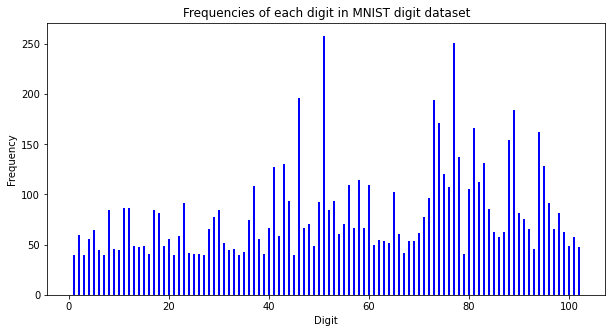

In [7]:
fig = plt.figure(figsize = (10, 5))

plt.bar(distinct_labels, frequencies, color ='blue', width = 0.4)
plt.xlabel("Digit")
plt.ylabel("Frequency")
plt.title("Frequencies of each digit in MNIST digit dataset")
plt.show()

In [ ]:
def load_images(height=200,width=200,folder_dir="flower_segmentations"):
  os.chdir('/content/drive/MyDrive/ML-Project')

  img_files=os.listdir(folder_dir)
  img_files=sorted(img_files)
  X_images=np.zeros((len(img_files),width,height,channel), dtype=np.int16)
  start_time=time.time()

  for index, row in enumerate(img_files):
      temp =cv2.imread(folder_dir+"/"+img_files[index])
      temp_resized=cv2.resize(temp,(height,width))
      #print(index)
      print(index)
      X_images[index,:,:,:]=temp_resized

  finish_time=time.time()
  elapsed_time=finish_time-start_time
  print(elapsed_time) #168.90791296958923
  f=open("all_images.py","wb")
  np.save(f,X_images)

  return X_images

In [11]:
#X_images=load_images()
f=open("all_images.py","rb")
X_images=np.load(f)

# Image Data Augmentation

In [8]:
def rotate( image, angle=90, scale=1.0):
        '''
        Rotate the image
        :param image: image to be processed
        :param angle: Rotation angle in degrees. Positive values mean counter-clockwise rotation (the coordinate origin is assumed to be the top-left corner).
        :param scale: Isotropic scale factor.
        '''
        angle=np.random.randint(15,360)
        w = image.shape[1]
        h = image.shape[0]
        #rotate matrix
        M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
        #rotate
        image = cv2.warpAffine(image,M,(w,h))
        return image

def flip( image, vflip=False, hflip=False):
        '''
        Flip the image
        :param image: image to be processed
        :param vflip: whether to flip the image vertically
        :param hflip: whether to flip the image horizontally
        '''
        
        if hflip or vflip:
            if hflip and vflip:
                c = -1
            else:
                c = 0 if vflip else 1
            image = cv2.flip(image, flipCode=c)
        return image 

def image_augment(image,i,save_path="/content/drive/MyDrive/ML-Project/augmented/"): 
        '''
        Create the new image with imge augmentation
        :param path: the path to store the new image
        ''' 
        img = image.copy()
        img=cv2.GaussianBlur(img,(5,5),0)
        s1=[True,False]

        img_flip = flip(img, vflip=s1[np.random.randint(0,2)], hflip=s1[np.random.randint(0,2)])
        img_rot = rotate(img_flip)
        
        zero_count=5-len(str(i))
        zeros=zero_count*"0"
        name=zeros+str(i)
        cv2.imwrite(save_path+'%s' %str(name)+'_.jpg', img_flip)
        return img_rot


In [ ]:
def augmentation(X_images,y_images,frequencies):
  rare_frequencies=frequencies[frequencies<150].index
  X_augmented=np.zeros((len(rare_frequencies)*10,width,height,channel), dtype=np.int16)
  y_augmented=np.zeros((10*len(rare_frequencies)))
  y_idx=0
  for i in rare_frequencies:
    y_augmented[y_idx:y_idx+0]=i
    y_idx+=10
  print(len(rare_frequencies))
 
  x_idx=0
  for label in rare_frequencies:
      indices=[label==y_images]
      X=X_images[indices]
      X=X[:10]
      for x in X:
          X_augmented[x_idx,:,:,:]=image_augment(x,x_idx+1)
          print(x_idx)
          x_idx+=1

  f=open("rare_augmented_x.py","wb")
  np.save(f,X_augmented)

  f=open("rare_augmented_y.py","wb")
  np.save(f,y_augmented)

  return X_augmented,y_augmented


In [9]:
#X_augmented,y_augmented=augmentation(X_images,y_images,frequencies)
f=open("rare_augmented_x.py","rb")
X_augmented=np.load(f)
f=open("rare_augmented_y.py","rb")
y_augmented=np.load(f)

In [12]:
X_data=np.r_[X_images,X_augmented]
y_data=np.r_[y_images,y_augmented]

In [13]:
del X_images,X_augmented

# Show Images

In [16]:
import matplotlib.pyplot as plt
import numpy as np
def show_images_with_objects(images, titles,shape=(200,200)):
  '''displays a row of images with corresponding titles'''
  plt.figure(figsize=(15, 15))
  row_size=5
  column_size=len(images)/row_size+len(images)%row_size
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(row_size, column_size, idx + 1)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(image)
    plt.title(title)

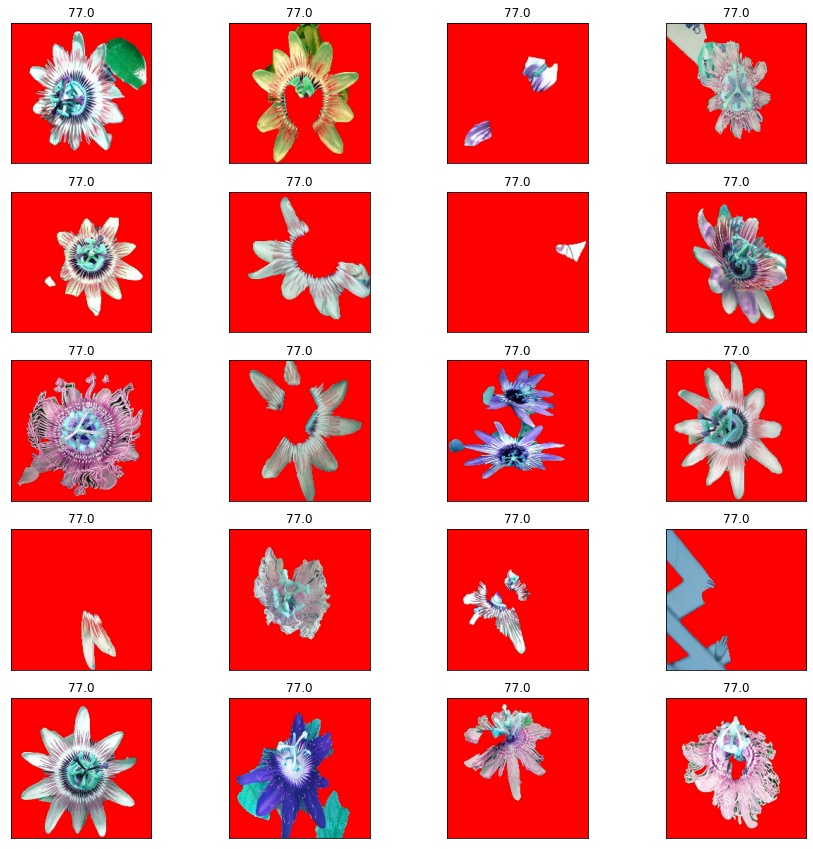

In [17]:
show_images_with_objects(X_data[:20,:],y_data[:20])

# Convert to Grayscale && uint8

In [ ]:
def rgb2gray(rgb):
  gray_scale=np.zeros((len(rgb),rgb.shape[1],rgb.shape[2]))
  for i in range(len(rgb)):
    gray_scale[i,:,:]=np.dot(rgb[i], [0.2989, 0.5870, 0.1140])
  return gray_scale


In [ ]:
X_data=rgb2gray(X_data)

In [ ]:
X_data = X_data.astype(np.uint8)

# Extract SIFT Features

In [ ]:
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 30.6 MB 89.3 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


**SIFT Feature Test on Single Sample**

In [ ]:
sift = cv2.xfeatures2d.SIFT_create() 
keypoints, descriptors = sift.detectAndCompute(X_data[968], None)

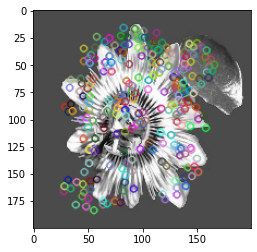

In [ ]:
#draw keypoints
sift_image = cv2.drawKeypoints(X_data[0], keypoints, None)

plt.imshow( sift_image)


**Extract SIFT Features of Whole Dataset**

In [ ]:
def extract_sift(X_images):

  os.chdir('/content/drive/MyDrive/ML-Project')
  dropped_idx=[]
  sift_features=np.zeros((len(X_images),20000))#40000

  for idx in range(len(X_images)):
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(X_images[idx], None)
    #print(idx)
    temp=np.ravel(descriptors)
    if(len(temp)>20000):
      temp=temp[:20000]
    if(None in temp):
        dropped_idx.append(idx)
        continue
    sift_features[idx,:len(temp)]=temp #feature_vector(sift)

  f=open('sift_with_aug.npy', 'wb')
  np.save(f,sift_features)
  return sift_features,dropped_idx

In [ ]:
#sift_features,dropped_idx=extract_sift(X_data)
#f=open('sift_with_aug.npy', 'rb')
#sift_features=np.load(f)

**Apply Bag of Words to SIFT features**

In [75]:
def BoW(features,numWords):
  voc, variance = kmeans(features, numWords, 3) 
  im_features = np.zeros((len(features), numWords), "float32")
  for i in range(len(im_features)):
    words, distance = vq(np.expand_dims(features[i],axis=0),voc)
    print(i)
    for w in words:
        im_features[i][w] += 1
  return im_features


In [ ]:
#im_features_sift=BoW(sift_features,3000) #numWords=3000 ---> this value is taken directly from the article
#f=open('im_features_sift_aug.npy', 'wb')
#np.save(f,im_features_sift)

In [18]:
f=open('im_features_sift_aug.npy', 'rb')
im_features_sift=np.load(f)

**Apply PCA to SIFT Features**

In [44]:
def apply_pca(features,y_images,distinct_labels,n_components=30):
  os.chdir('/content/drive/MyDrive/ML-Project')
  variance_pca=[]
  features_reduced=np.zeros((len(features),n_components))

  idx=0
  for index in distinct_labels:
      indices = (y_images == index)
      Xd = features[indices,:]

      pca = PCA(n_components=n_components)     
      scores = pca.fit_transform(Xd)
      features_reduced[idx:idx+len(scores),:]= scores
      variance_pca.append(np.sum(pca.explained_variance_ratio_))   
      idx+=len(scores)

  return features_reduced,variance_pca

In [286]:
sift_features_reduced,variance_pca = apply_pca(im_features_sift,y_data,distinct_labels,35)
#f=open('sift_reduced_aug.npy', 'wb')
#np.save(f,sift_features_reduced)

In [287]:
print("Avarage explained variance ratio is: ", np.mean(variance_pca))

Avarage explained variance ratio is:  0.86459464


Text(0.5, 0, 'Class')

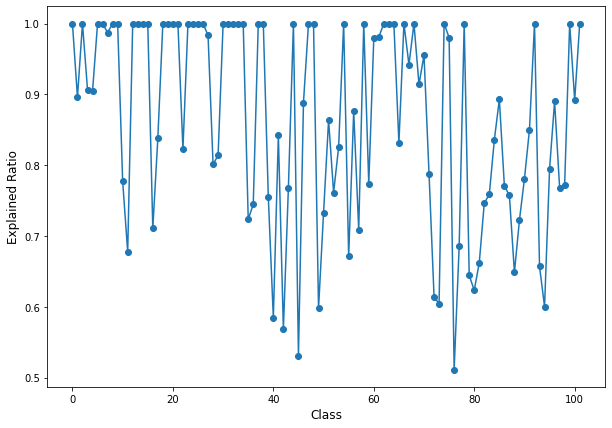

In [288]:
plt.figure(figsize=(10,7))
plt.plot(variance_pca)
plt.scatter(range(len(variance_pca)),variance_pca)
plt.ylabel("Explained Ratio",fontsize=12)
plt.xlabel("Class",fontsize=12)

# Extract ORB Features

In [42]:
def extract_orb(X_images):
  orb_features=np.zeros((len(X_images),10000))
  dropped_idx=[]
  orb=cv2.ORB_create()
  for idx in range(len(X_images)):
    keypoints,descriptor= orb.detectAndCompute(X_images[idx],None)
    temp=np.ravel(descriptor)
    if(len(temp)>10000):
      temp=temp[:10000]
    if(None in temp):
        dropped_idx.append(idx)
        continue
    orb_features[idx,:len(temp)]=temp #feature_vector(orb)
    #print(idx)

  f=open('orb_aug.npy', 'wb')
  np.save(f,orb_features)
  return orb_features,dropped_idx
  

In [ ]:
#orb_features,dropped_idx=extract_orb(X_data)
#f=open('orb_aug.npy', 'rb')
#orb_features=np.load(f)

**Apply Bag of Words to ORB features**

In [ ]:
#im_features_orb=BoW(orb_features,800)
#f=open('im_features_orb_aug.npy', 'wb')
#np.save(f,im_features_orb)


In [38]:
f=open('im_features_orb_aug.npy', 'rb')
im_features_orb=np.load(f)

**Apply PCA to ORB Features**

In [283]:
orb_reduced,variance_pca=apply_pca(im_features_orb,y_data,distinct_labels,40)#10

In [284]:
print("Avarage explained variance ratio is: ", np.mean(variance_pca))

Avarage explained variance ratio is:  0.8026


Text(0.5, 0, 'Class')

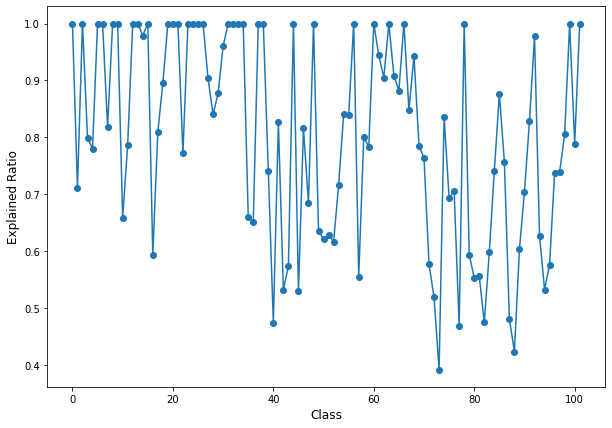

In [285]:
plt.figure(figsize=(10,7))
plt.plot(variance_pca)
plt.scatter(range(len(variance_pca)),variance_pca)
plt.ylabel("Explained Ratio",fontsize=12)
plt.xlabel("Class",fontsize=12)

# Extract Hog Features

In [ ]:
def extract_hog(X_images):
  os.chdir('/content/drive/MyDrive/ML-Project')
  hog_features=hog_features=np.zeros((len(X_images),20736))

  for idx in range(len(X_images)):
    X_images[idx]=cv2.GaussianBlur(X_images[idx],(5,5),0) #Gaussian Filtering 
    fd, hog_img= hog(X_images[idx], orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True)
    #print(idx)
    hog_features[idx,:]=fd #feature_vector(hog)

  f=open('hog_aug.npy', 'wb')
  np.save(f,hog_features)
  return hog_features
  

In [ ]:
#hog_features=extract_hog(X_data)
#f=open("hog.npy","rb")
#hog_features=np.load(f)

**Apply Bag of Words to HOG features**

In [ ]:
#im_features_hog=BoW(hog_features,1500) #numWords=15000 ---> this value is taken directly from the article
#f=open('im_features_hog_aug.npy', 'wb')
#np.save(f,im_features_hog)

In [53]:
f=open('im_features_hog_aug.npy', 'rb')
im_features_hog=np.load(f) 

**Apply PCA to HOG Features**

In [280]:
hog_features_reduced,variance_pca=apply_pca(im_features_hog,y_data,distinct_labels,30)

In [281]:
print("Avarage explained variance ratio is: ", np.mean(variance_pca))

Avarage explained variance ratio is:  0.8847885


Text(0.5, 0, 'Class')

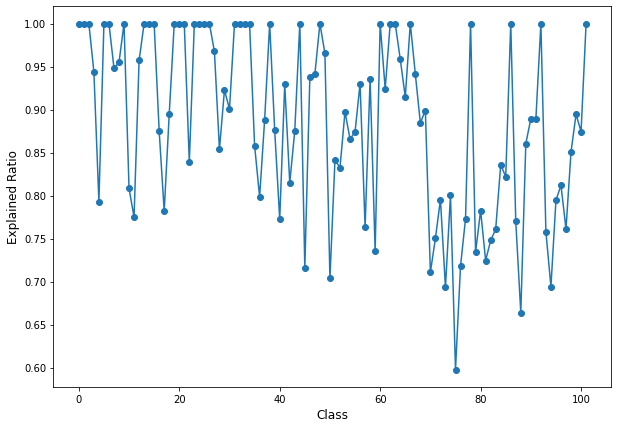

In [282]:
plt.figure(figsize=(10,7))
plt.plot(variance_pca)
plt.scatter(range(len(variance_pca)),variance_pca)
plt.ylabel("Explained Ratio",fontsize=12)
plt.xlabel("Class",fontsize=12)

# Extract KAZE Features

In [ ]:
def extract_kaze(X_images):


  os.chdir('/content/drive/MyDrive/ML-Project')
  
  dropped_idx=[]
  sift_features=np.zeros((len(X_images),3000))#40000

  kaze = cv2.AKAZE_create()

  for idx in range(len(X_images)):
    
    keypoints, descriptors = kaze.detectAndCompute(X_data[idx], None)
    print(idx)
    temp=np.ravel(descriptors)
    if(len(temp)>3000):
      temp=temp[:3000]
    if(None in temp):
        dropped_idx.append(idx)
        continue
    sift_features[idx,:len(temp)]=temp #feature_vector(sift)

  f=open('kaze_with_aug.npy', 'wb')
  np.save(f,sift_features)
  return sift_features,dropped_idx


In [58]:
#kaze_features,dropped_idx=extract_kaze(X_data)
f=open('kaze_with_aug.npy', 'rb')
kaze_features=np.load(f)

**Apply Bag of Words to KAZE Features**

In [ ]:
#im_features_kaze=BoW(kaze_features,800)

In [78]:
#f=open("im_features_kaze_aug.npy","wb")
#np.save(f,im_features_kaze)

In [ ]:
f=open("im_features_kaze_aug.npy","rb")
im_features_kaze=np.load(f)

**Apply PCA to KAZE**

In [277]:
kaze_features_reduced,variance_pca =apply_pca(im_features_kaze,y_data,distinct_labels,30)

In [278]:
print("Avarage explained variance ratio is: ", np.mean(variance_pca))

Avarage explained variance ratio is:  0.8185519


Text(0.5, 0, 'Class')

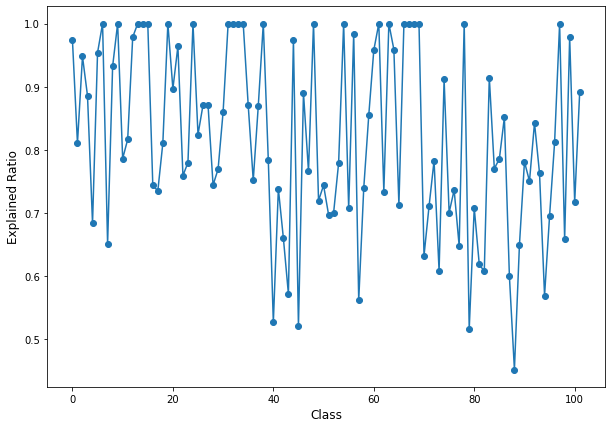

In [279]:
plt.figure(figsize=(10,7))
plt.plot(variance_pca)
plt.scatter(range(len(variance_pca)),variance_pca)
plt.ylabel("Explained Ratio",fontsize=12)
plt.xlabel("Class",fontsize=12)

# Extract BRISK Features

In [ ]:
def extract_brisk(X_images):

  os.chdir('/content/drive/MyDrive/ML-Project')
  dropped_idx=[]
  brisk_features=np.zeros((len(X_images),5000))#40000

  brisk = cv2.BRISK_create()
  for idx in range(len(X_images)):
    keypoints, descriptors = brisk.detectAndCompute(X_images[idx], None)
    #print(idx)
    temp=np.ravel(descriptors)
    if(len(temp)>5000):
      temp=temp[:5000]
    if(None in temp):
        dropped_idx.append(idx)
        continue
    brisk_features[idx,:len(temp)]=temp #feature_vector(sift)

  f=open('brisk_with_aug.npy', 'wb')
  np.save(f,brisk_features)
  return brisk_features,dropped_idx

In [ ]:
#brisk_features,dropped_idx=extract_brisk(X_data)

**Apply Bag of Words to BRISK features**

In [ ]:
#im_features_brisk=BoW(brisk_features,1000)
#f=open("im_features_brisk_aug.npy","wb")
#np.save(f,im_features_brisk)

In [99]:
f=open("im_features_brisk_aug.npy","rb")
im_features_brisk=np.load(f)

**Apply PCA to BRISK**

In [274]:
brisk_features_reduced,variance_pca=apply_pca(im_features_brisk,y_data,distinct_labels,30)

In [275]:
print("Avarage explained variance ratio is: ", np.mean(variance_pca))

Avarage explained variance ratio is:  0.8807315


Text(0.5, 0, 'Class')

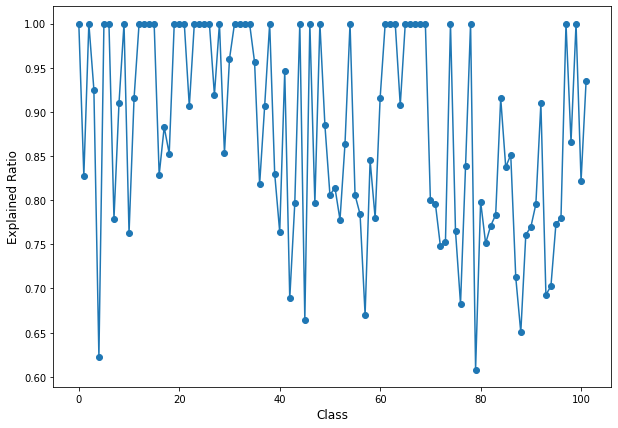

In [276]:
plt.figure(figsize=(10,7))
plt.plot(variance_pca)
plt.scatter(range(len(variance_pca)),variance_pca)
plt.ylabel("Explained Ratio",fontsize=12)
plt.xlabel("Class",fontsize=12)

#**Classification**

In [373]:
#We determined how many features we should take by observing importance plot created through random forest classifier 
all_features=np.c_[hog_features_reduced[:,:6],sift_features_reduced[:,:9],orb_reduced[:,:10],kaze_features_reduced[:,:10],brisk_features_reduced[:,:10]] 

In [383]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
all_features_scaled=sc.fit_transform(all_features)

In [384]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

#0.6820175438596491
y_images=y_data.reshape(len(y_data),1)
X_train, X_test, y_train, y_test = train_test_split(all_features_scaled[:,],y_images[:], test_size=0.3, random_state=123) 

In [385]:
classifier = RandomForestClassifier(n_estimators=300,random_state = 123)
classifier.fit(X_train, y_train)
test_accuracy = classifier.score(X_test, y_test)#wo kaze
print(test_accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.6867690058479532


In [377]:
def forward_selection(X_train, X_test, y_train, y_test):
  features=[]
  max_accuracy=0
  clf=RandomForestClassifier(n_estimators=200)
  p=X_train.shape[1]
  dimensions=list(range(p))
  

  flag=False    
  for i in range(p):
    """
    if(flag):
        break
    """
    for dim in (set(dimensions)-set(features)):

        temp=list([*features])
        temp.append(dim)
        clf.fit(X_train[:,[*temp]],y_train)
        y_pred=clf.predict(X_test[:,[*temp]])
        accuracy=accuracy_score(y_test,y_pred)
        if accuracy > max_accuracy: #I added this condition to be able to limit the number of features selected by the algorithm with 2

              max_accuracy=accuracy                         
              feature_to_appended=dim

        if feature_to_appended in features: #selected subset of columns already gives the lowest error so no need to add a new dimension
            flag=True
        else: 
            features.append(feature_to_appended)
            #print(feature_to_appended)
           
    return features

In [ ]:
selected_features=forward_selection(X_train, X_test, y_train, y_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_features_scaled[:,selected_features],y_images[:], test_size=0.3, random_state=123) 

In [380]:
classifier = RandomForestClassifier(n_estimators=300,random_state = 123)
classifier.fit(X_train, y_train)
test_accuracy = classifier.score(X_test, y_test)#wo kaze
print(test_accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.6900584795321637


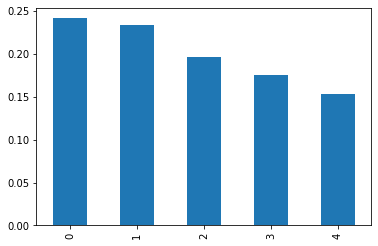

In [381]:
importances = classifier.feature_importances_
forest_importances = pd.Series(importances)
forest_importances.plot.bar()

In [220]:
y_pred=classifier.predict(X_test)

In [245]:
print("\nClassification report:\n", classification_report(y_test,y_pred))


Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       261
         1.0       0.71      0.83      0.77        12
         2.0       0.23      0.15      0.18        20
         3.0       0.33      0.33      0.33         9
         4.0       0.27      0.21      0.24        19
         5.0       0.33      0.58      0.42        19
         6.0       0.22      0.13      0.17        15
         7.0       0.29      0.18      0.22        11
         8.0       0.77      0.53      0.62        19
         9.0       0.62      0.31      0.42        16
        10.0       0.25      0.20      0.22        15
        11.0       0.79      0.71      0.75        31
        12.0       0.67      1.00      0.80        22
        13.0       0.14      0.23      0.18        13
        14.0       0.43      0.69      0.53        13
        15.0       0.44      0.92      0.59        12
        16.0       0.83      0.67      0.74        15
  